In [1]:
import numpy as np
import torch
import time
import psutil
import sys
sys.path.append("../")
import NewtonMethod
import gaussianKernel
import losses
import display
import Katyusha
from importlib import reload

## Pre-processing

In [2]:
# loading file

filepath= "../DATASETS/Higgs.pt"
X = torch.load(filepath)

# shuffle file

n = X.size(0)
d = X.size(1)-1
l = np.array(range(n))
np.random.shuffle(l)
X = X[l,:]
del l


# divide in training and test set 

ntr = int(np.ceil(n*0.8))
nts = n - ntr

Xtr = X[:ntr,1:]
Xts = X[ntr:,1:]
Ytr = X[:ntr,0].unsqueeze_(1)
Yts = X[ntr:,0].unsqueeze_(1)
del X

# processing training features : centering and renormalizing

def recenter(W,m,s):
    W-= m.unsqueeze(0).expand_as(W)
    W /= s.unsqueeze(0).expand_as(W)
    
m = Xtr.mean(0)
s = Xtr.std(0)
recenter(Xtr,m,s)
recenter(Xts,m,s)
del m
del s

# putting labels to -1,1

Ytr *= 2
Ytr -= 1
Yts *= 2
Yts -= 1

## Performing Newton Method with 1e4 nystrom points and comparing Kat and Newton Method

In [ ]:
# Nystrom points
m = 10000
l = np.array(range(ntr))
np.random.shuffle(l)
l = l[:m]
C = Xtr[l,:]
yC = Ytr[l,:]
# loss

loss = losses.logloss

#UseGPU
useGPU = True
memToUse = 0.9*psutil.virtual_memory().available
saveFolder = "HiggsData/logloss_first_round"

In [ ]:
sigma = 5
kern = gaussianKernel.gaussianKernel(sigma)

In [ ]:
torch.cuda.empty_cache()

#parameters for Katyusha
la = 1e-9
Nepochs = 40
cobjK = display.cobjTestK(Xts,Yts,saveFolder)

#Perform Katyusha
al = Katyusha.miniBatchKSVRG(loss,Xtr,C,Ytr,yC,kern,la,Nepochs,mratio=2,memToUse = memToUse,useGPU = useGPU,cobj = cobjK)

torch.cuda.empty_cache()

#Parameters for Newton Method
la_list = [1e-3,1e-6,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9]
t_list = [3,3,3,8,8,8,8,8,8,8,8,8,8,8]
cobj = display.cobjTest(Xts,Yts,saveFolder)

#Perform Newton method
alpha = NewtonMethod.NewtonMethod(loss,Xtr,C,Ytr,yC,kern,la_list,t_list,memToUse = memToUse,cobj = cobj)

## Performing the Newton Method alone 

In [3]:
# Nystrom points
m = 25000
l = np.array(range(ntr))
np.random.shuffle(l)
l = l[:m]
C = Xtr[l,:]
yC = Ytr[l,:]
# loss

#UseGPU
useGPU = True
memToUse = 0.9*psutil.virtual_memory().available
print(memToUse)

77719991500.8


In [4]:
sigma = 5
kern = gaussianKernel.gaussianKernel(sigma)

Testing for two losses 

In [ ]:
torch.cuda.empty_cache()

loss = losses.logloss
saveFolder = "HiggsData/logloss_second_round"

#Parameters for Newton Method
la_list = [1e-3,1e-6,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9]
t_list = [3,3,3,8,8,8,8,8,8,8,8,8,8,8]
cobj = display.cobjTest(Xts,Yts,saveFolder)

#Perform Newton method
alpha = NewtonMethod.NewtonMethod(loss,Xtr,C,Ytr,yC,kern,la_list,t_list,memToUse = memToUse,cobj = cobj)

torch.cuda.empty_cache()

loss = losses.squareloss
saveFolder = "HiggsData/squareloss_second_round"

#Parameters for Newton Method
la_list = [1e-9]
t_list = [60]
cobj = display.cobjTest(Xts,Yts,saveFolder)

#Perform Newton method
alpha = NewtonMethod.NewtonMethod(loss,Xtr,C,Ytr,yC,kern,la_list,t_list,memToUse = memToUse,cobj = cobj)

there is 14.581201171875 GiB free on the GPU 
number of approximate newton steps performed : 0         in 256.0967562198639 seconds
Performed 1 steps of the conjugate gradient method


# Plots

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
m = 10000
sigma = 5

In [29]:
la = 1e-9
path = "HiggsData/logloss_first_round"
titleNewton = "m = {}, la = {}.csv".format(m,la)
titleKatyusha =  "Katyusha "+titleNewton
dfNewton = pd.read_csv(path + titleNewton)
dfKatyusha = pd.read_csv(path +titleKatyusha)
figure_path = "HiggsData/figures/"

In [30]:
trainN = np.array(dfNewton['optimization loss'])
testN = np.array(dfNewton['test error'])
timeN = np.array(dfNewton['time'])/60
passesN = np.array(dfNewton['conjugate gradient steps'])

trainK = np.array(dfKatyusha['optimization loss'])
testK = np.array(dfKatyusha['test error'])
timeK = np.array(dfKatyusha['time'])/60
passesK = np.array(dfKatyusha['number of passes'])

In [31]:
mi =min([min(trainN),min(trainK)])
g = 5e-7
dTrainN = trainN -mi +g
dTrainK = trainK -mi +g

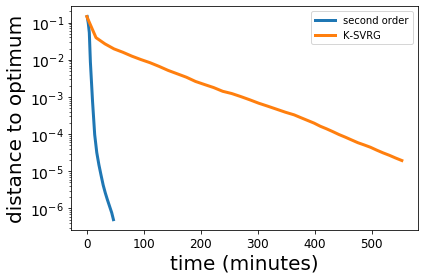

In [32]:
fig = plt.figure()
plt.semilogy(timeN,dTrainN,lw = 3,label = 'second order')
plt.semilogy(timeK,dTrainK,lw = 3,label = 'K-SVRG')
plt.legend()
plt.xlabel("time (minutes)",fontsize = 20)
plt.ylabel("distance to optimum",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
fig.savefig(figure_path  + 'distance = f(time) with m={}, la={}.pdf'.format(m,la) , format='pdf', dpi=1000)
plt.show()

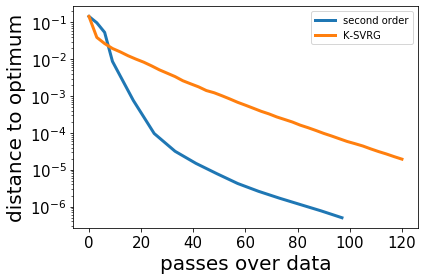

In [33]:
fig = plt.figure()
plt.semilogy(passesN,dTrainN,lw = 3,label = 'second order')
plt.semilogy(passesK,dTrainK,lw = 3,label = 'K-SVRG')
plt.legend()
plt.xlabel("passes over data",fontsize = 20)
plt.ylabel("distance to optimum",fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.tight_layout()
#fig.savefig(figure_path  + 'distance = f(passes) with m={}, la={}.pdf'.format(m,la) , format='pdf', dpi=1000)
plt.show()

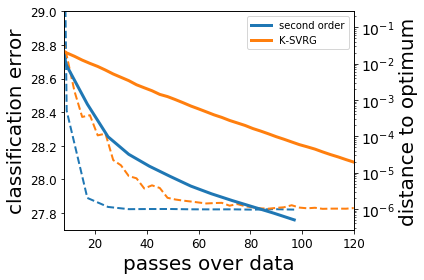

In [34]:
fig, ax1 = plt.subplots()
ax1.plot(passesN,testN,'--',lw = 2,label = 'second order')
ax1.plot(passesK,testK,'--',lw = 2,label = 'K-SVRG')
ax1.set_xlabel("passes over data",fontsize = 20)
ax1.set_ylabel("classification error",fontsize = 20)
ax1.tick_params(labelsize=14)
ax1.tick_params(labelsize=12)
ax1.set_ylim(27.7,29)
ax1.set_xlim(8,120)
ax2 = ax1.twinx()
ax2.plot(passesN,dTrainN,lw = 3,label = 'second order')
ax2.plot(passesK,dTrainK,lw = 3,label = 'K-SVRG')
ax2.legend()
ax2.set_yscale('log')
ax2.set_ylabel("distance to optimum",fontsize = 20)
plt.tick_params(labelsize=14)
fig.tight_layout()
fig.savefig(figure_path  + 'distance,class = f(passes) with m={}, la={}.pdf'.format(m,la) , format='pdf', dpi=1000)
fig.show()